In [41]:
import numpy as np
from scipy.linalg import eig, logm
import matplotlib.pyplot as plt

In [ ]:
def analytic_edmd(X, Y, equilibrium_point, kernel_func, basis_funcs, degrees, on=False, delta_t=None, continuous_time=False):
    """
    Implementation of Analytic EDMD Algorithm
    
    Parameters:
    -----------
    X, Y tipa m x n (m je broj podataka)
    equilibrium_point : array-like
        The equilibrium point x*
    kernel_func : function
        The Taylor-type kernel function k
    basis_funcs : list of functions
        Basis of (weighted) monomials {e_i}
    degrees: number
        degrees for each of the basis functions
    on: bool,
        Whether basis is orthonormal (True) or not (False)
    delta_t : float, optional
        Sampling time for continuous-time systems
    continuous_time : bool, optional
        Whether to treat as continuous-time system
    
    Returns:
    --------
    K : ndarray
        Koopman matrix approximation
    S : list
        Set of Koopman eigenvalues
    v_coeffs : dict
        Dictionary of Taylor coefficients for principal eigenfunctions
    """
    
    # 1
    equilibrium_point = equilibrium_point.reshape(1,-1)
    X = X-equilibrium_point
    Y = Y-equilibrium_point
    M = X.shape[0]
    N = len(basis_funcs)
    
    # 2 - kreiram G
    G = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            G[i, j] = kernel_func(X[i,:], X[j,:])
    print("G:",G)
    
    # 3 - kreiram X i Y (tj B_X i B_Y)
    B_X = np.zeros((M, N))
    B_Y = np.zeros((M, N))
    for i in range(M):
        for j in range(N):
            B_X[i, j] = basis_funcs[j](X[i,:])
            B_Y[i, j] = basis_funcs[j](Y[i,:])
    
    # 4 - racunam K
    G_inv = np.linalg.pinv(G)
    if(on):
        K = B_X.T @ G_inv @ B_Y
    else:
        K = np.linalg.pinv(B_X.T @ G_inv @ B_X) @ (B_X.T @ G_inv @ B_Y)    
    
    print("K.shape:", K.shape)
    print(K)
    # Determine the block structure based on polynomial degrees
    # This assumes the basis is ordered by increasing degree
    # You may need to modify this based on your specific basis ordering

    #### trebalo bi input stupnja...
    """ block_indices = [0]
    current_degree = 0
    for i, f in enumerate(basis_funcs):
        if degrees[i] > current_degree:
            block_indices.append(i)
            current_degree = estimate_degree(f)
    block_indices.append(N)"""
    
    # Step 5-7: Compute Koopman eigenvalues
    S = []
    degrees=np.array(degrees)
    max_degree=np.max(degrees)
    for r in range(1,max_degree+1):
        indices = np.where(degrees == r)[0]
        K_rr = K[np.ix_(indices, indices)]
        print("indices, K_rr:",indices, K_rr)
        eigvals = np.linalg.eigvals(K_rr)
        S.extend(eigvals) #extend - da nadopunim s listom 
    
    if continuous_time and delta_t is not None:
        # Step 8: Convert to continuous-time eigenvalues
        S = [np.log(mu)/delta_t for mu in S if mu != 0]  # maknemo nule, ali lose..
    
    # Steps 9-15: Compute principal Koopman eigenfunctions
    # Start with first block
    indices = np.where(degrees == 1)[0]
    K_11 = K[np.ix_(indices, indices)]
    eigvals_11, eigvecs_11 = eig(K_11)
    
    n = len(indices) # Dimension of first block
    v_coeffs = []
    all_v = []
    for j in range(n):
        mu_j = eigvals_11[j]
        w_j = eigvecs_11[:, j]

        # Initialize coefficients
       
        all_v.append([])
        v_coeffs=all_v[-1]

        v_coeffs.append(w_j)
        #print("v_coeffs", v_coeffs, len(v_coeffs), v_coeffs[0][1])
        
        # Recursively compute coefficients for higher degree blocks
        for r in range(2, max_degree+1):
            indices_r = np.where(degrees==r)[0]
            K_rr = K[np.ix_(indices_r, indices_r)]
            
            # Compute the sum term
            sum_term = np.zeros(len(indices_r), dtype=complex)
            for s in range(1,r):
                indices_s = np.where(degrees==s)[0]
                K_rs = K[np.ix_(indices_r, indices_s)]
                #print("K_rs.shape, v_coeffs[j][s+1].shape:",K_rs.shape, v_coeffs[j][s+1].shape)
                sum_term += K_rs @ v_coeffs[s-1]
            
            
            print(indices_r)
            # Solve for v_r^(j)
            try:
                sum_term = np.linalg.solve(K_rr - mu_j * np.eye(len(indices_r)), sum_term)
            except np.linalg.LinAlgError:
                # Use least squares if matrix is singular
                sum_term = np.linalg.lstsq(K_rr - mu_j * np.eye(len(indices_r)), sum_term, rcond=None)[0]

            v_coeffs.append(sum_term)
            print(v_coeffs)
        all_v[-1] = v_coeffs

    return K, S, all_v

"""def estimate_degree(basis_func):
    
    #Helper function to estimate the degree of a basis function.
    #This is a placeholder - you'll need to implement this based on your specific basis functions.
    
    # This is a simple example - you'll need to modify based on your basis
    if hasattr(basis_func, '__name__'):
        if 'linear' in basis_func.__name__:
            return 1
        elif 'quadratic' in basis_func.__name__:
            return 2
    return 1  # Default to degree 1"""

"def estimate_degree(basis_func):\n    \n    #Helper function to estimate the degree of a basis function.\n    #This is a placeholder - you'll need to implement this based on your specific basis functions.\n    \n    # This is a simple example - you'll need to modify based on your basis\n    if hasattr(basis_func, '__name__'):\n        if 'linear' in basis_func.__name__:\n            return 1\n        elif 'quadratic' in basis_func.__name__:\n            return 2\n    return 1  # Default to degree 1"

In [80]:
# Example usage with simple polynomial basis

# Define a simple kernel function (linear kernel for example)
def linear_kernel(x, y):
    return np.dot(x, y)

# Define simple monomial basis functions
def e1(x): return 1.0
def e2(x): return x[0]
def e3(x): return x[1]
def e4(x): return x[0]**2
def e5(x): return x[0]*x[1]
def e6(x): return x[1]**2

basis = [e1, e2, e3, e4, e5, e6]

X = np.array([0.3,0.7]).reshape(-1,1)
A = np.diag((0.6, 0.8))
A[0,1] = 0.3

M=10
for i in range(M):
    X = np.hstack((X, A@(X[:,-1].reshape(-1,1))))

Y = X[:,1:].T
X = X[:,:-1].T


In [68]:
X.shape

(10, 2)

In [81]:
K, eigenvalues, eigenfunction_coeffs = analytic_edmd(
    X, Y,
    equilibrium_point=np.array([0.0, 0.0]),
    kernel_func=linear_kernel,
    basis_funcs=basis,
    degrees=np.array([0,1,1,2,2,2]),
    delta_t=0.1,
    continuous_time=False
)

print("Koopman matrix approximation:")
print(K)
print("\nKoopman eigenvalues:")
print(eigenvalues)
print("\nEigenfunction coefficients:")
print(eigenfunction_coeffs)

G: [[0.58       0.509      0.4342     0.36356    0.300568   0.2462864
  0.20052832 0.16252218 0.13127745 0.10577779]
 [0.509      0.4657     0.40766    0.347188   0.2903864  0.23989072
  0.19646154 0.1598986  0.12955651 0.10462778]
 [0.4342     0.40766    0.362308   0.3115544  0.26226832 0.21762954
  0.17879256 0.1458474  0.11836594 0.09570556]
 [0.36356    0.347188   0.3115544  0.26952592 0.22779018 0.1895338
  0.15600804 0.12743503 0.10352519 0.08376644]
 [0.300568   0.2903864  0.26226832 0.22779018 0.19301745 0.16088515
  0.13259083 0.10840229 0.08811961 0.07133435]
 [0.2462864  0.23989072 0.21762954 0.1895338  0.16088515 0.13426298
  0.1107433  0.09059439 0.07367537 0.0596602 ]
 [0.20052832 0.19646154 0.17879256 0.15600804 0.13259083 0.1107433
  0.09139703 0.07479905 0.0608481  0.04928379]
 [0.16252218 0.1598986  0.1458474  0.12743503 0.10840229 0.09059439
  0.07479905 0.06123336 0.04982316 0.04036041]
 [0.13127745 0.12955651 0.11836594 0.10352519 0.08811961 0.07367537
  0.0608481 

In [64]:
np.linalg.eigvals(K)

array([ 0.00000000e+00,  9.21047889e-01,  5.90391096e-01, -7.67402490e-17,
        6.31835874e-17,  2.85757855e-18])

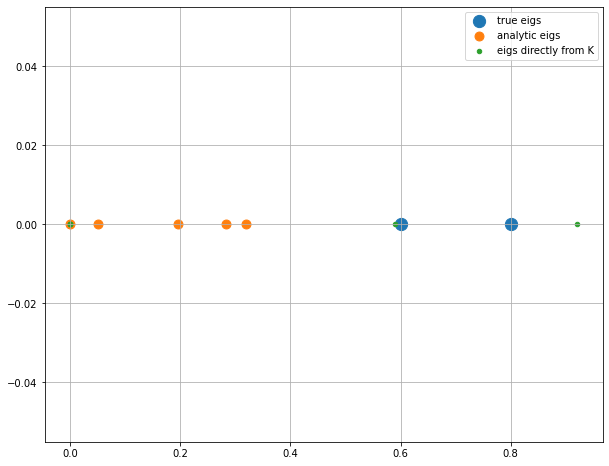

In [65]:
fig = plt.figure(figsize=(10,8))
plt.scatter(np.real(np.linalg.eigvals(A)), np.imag(np.linalg.eigvals(A)), s=150, label="true eigs")
plt.scatter(np.real(eigenvalues), np.imag(eigenvalues), s=80, label="analytic eigs")
plt.scatter(np.real(np.linalg.eigvals(K)), np.imag(np.linalg.eigvals(K)), label="eigs directly from K", s=20)
plt.grid()
plt.legend()